In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from matplotlib import pyplot as plt
import math
from zipfile import ZipFile

In [ ]:
%%shell
gdown 1Ixr3-nKsI1rJUH6SCWQd8noysUAp6YGd

Downloading...
From: https://drive.google.com/uc?id=1Ixr3-nKsI1rJUH6SCWQd8noysUAp6YGd
To: /content/Images.zip
100% 1.64M/1.64M [00:00<00:00, 102MB/s]


In [ ]:
with ZipFile("/content/Images.zip", 'r') as file:
	file.extractall(path="/content/")

In [ ]:
img1_l = cv2.imread("/content/l1.png", cv2.IMREAD_GRAYSCALE)
img1_r = cv2.imread("/content/r1.png", cv2.IMREAD_GRAYSCALE)
img2_l = cv2.imread("/content/l2.png", cv2.IMREAD_GRAYSCALE)
img2_r = cv2.imread("/content/r2.png", cv2.IMREAD_GRAYSCALE)
img3_l = cv2.imread("/content/l3.png", cv2.IMREAD_GRAYSCALE)
img3_r = cv2.imread("/content/r3.png", cv2.IMREAD_GRAYSCALE)

In [ ]:
def plot_img(fig, rows, cols, id, img, title):
  ax = fig.add_subplot(rows, cols, id)
  imgplot = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
  ax.set_title(title)
  ax.tick_params(left = False, right = False , labelleft = False , labelbottom = False, bottom = False)

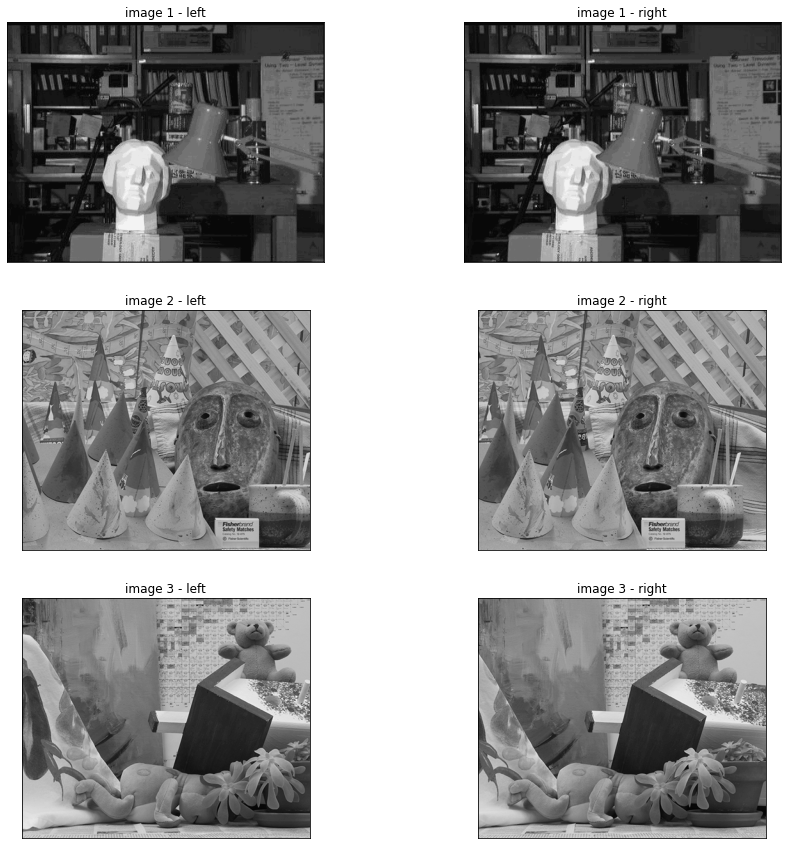

In [ ]:
fig = plt.figure(figsize=(15,15))
plot_img(fig, 3, 2, 1, img1_l, 'image 1 - left')
plot_img(fig, 3, 2, 2, img1_r, 'image 1 - right')
plot_img(fig, 3, 2, 3, img2_l, 'image 2 - left')
plot_img(fig, 3, 2, 4, img2_r, 'image 2 - right')
plot_img(fig, 3, 2, 5, img3_l, 'image 3 - left')
plot_img(fig, 3, 2, 6, img3_r, 'image 3 - right')

## Block Matching

* Matching each pixel in the left image to a pixel in the right image.
* Since there is no rectification needed --> only need to match the row in the left image with its equivalent in the right image. 
* Calculate the disparity in two ways:
> 1. using the cost as the Sum of Absolute Differences (SAD)
> 2. using Sum of Squared Difference (SSD) 

* For windows of sizes --> w = 1, 5 and 9. 
* Produce 6 maps: 2 maps for each window size, once using SAD and the other using SSD.

In [ ]:
def get_windows_lists(left_img, right_img, scanline, pixel_in_left, w, offset):
  left_padded = np.pad(left_img, w//2, 'constant')
  right_padded = np.pad(right_img, w//2, 'constant')
  left = left_padded[scanline : scanline + w , pixel_in_left : pixel_in_left + w]
  right = []
  start = 0 if pixel_in_left < offset else pixel_in_left - offset
  end =  pixel_in_left + 1 if pixel_in_left != right_img.shape[1] - 1 else right_img.shape[1]
  for r in range(start, end):
    right.append(right_padded[scanline : scanline + w , r : r + w])

  return left, np.asarray(right, dtype=np.int32)

In [ ]:
def normalize(A, max):
  return ((A - np.min(A)) * max) // (np.max(A) - np.min(A))

In [ ]:
def calculate_SAD(left, right):
  return np.sum(np.abs(np.array(left - right, dtype=int)))

In [ ]:
def calculate_SSD(left, right):
  return np.sum(np.square(np.array(left - right, dtype=int)))

In [ ]:
def block_matching(left_img, right_img, disparity_method, best_val_method, w, offset):
  disp = np.zeros(left_img.shape)
  for sl in range(left_img.shape[0]):
    for l in range(left_img.shape[1]):
      left, right = get_windows_lists(left_img, right_img, sl, l, w, offset)
      vals = []
      for r in right:
        vals.append(disparity_method(left.flatten(), r.flatten()))
      disp[sl][l] = len(vals) - best_val_method(np.array(vals))
  
  disp = normalize(disp, 255)
  return np.array(disp)

In [ ]:
def plot_SAD_SSD_disp(title, img_SAD_1, img_SAD_5, img_SAD_9, img_SSD_1, img_SSD_5, img_SSD_9):
  fig = plt.figure(figsize=(15,10))
  print(title)
  plot_img(fig, 2, 3, 1, np.abs(img_SAD_1), 'SAD: w = 1')
  plot_img(fig, 2, 3, 2, np.abs(img_SAD_5), 'SAD: w = 5')
  plot_img(fig, 2, 3, 3, np.abs(img_SAD_9), 'SAD: w = 9')
  plot_img(fig, 2, 3, 4, np.abs(img_SSD_1), 'SSD: w = 1')
  plot_img(fig, 2, 3, 5, np.abs(img_SSD_5), 'SSD: w = 5')
  plot_img(fig, 2, 3, 6, np.abs(img_SSD_9), 'SSD: w = 9')

Image 1 using SAD and SSD


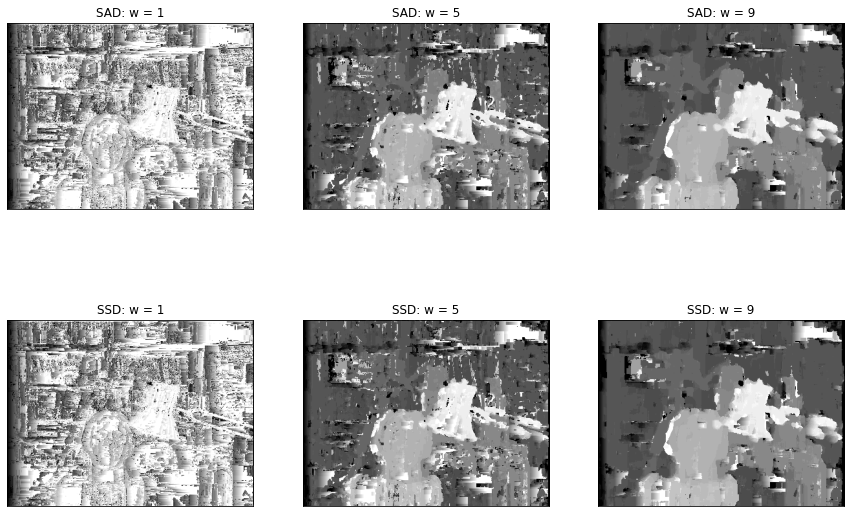

In [ ]:
disp_img1_SAD_1 = block_matching(img1_l, img1_r, calculate_SAD, np.argmin, 1, 30)
disp_img1_SAD_5 = block_matching(img1_l, img1_r, calculate_SAD, np.argmin, 5, 30)
disp_img1_SAD_9 = block_matching(img1_l, img1_r, calculate_SAD, np.argmin, 9, 30)
disp_img1_SSD_1 = block_matching(img1_l, img1_r, calculate_SSD, np.argmin, 1, 30)
disp_img1_SSD_5 = block_matching(img1_l, img1_r, calculate_SSD, np.argmin, 5, 30)
disp_img1_SSD_9 = block_matching(img1_l, img1_r, calculate_SSD, np.argmin, 9, 30)

plot_SAD_SSD_disp('Image 1 using SAD and SSD', disp_img1_SAD_1, disp_img1_SAD_5, 
                  disp_img1_SAD_9, disp_img1_SSD_1, disp_img1_SSD_5, disp_img1_SSD_9)

Image 2 using SAD and SSD


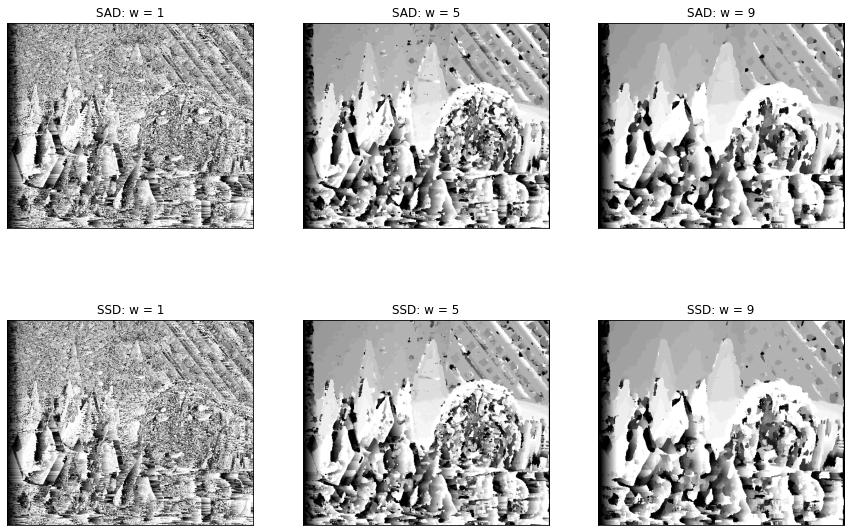

In [ ]:
disp_img2_SAD_1 = block_matching(img2_l, img2_r, calculate_SAD, np.argmin, 1, 30)
disp_img2_SAD_5 = block_matching(img2_l, img2_r, calculate_SAD, np.argmin, 5, 30)
disp_img2_SAD_9 = block_matching(img2_l, img2_r, calculate_SAD, np.argmin, 9, 30)
disp_img2_SSD_1 = block_matching(img2_l, img2_r, calculate_SSD, np.argmin, 1, 30)
disp_img2_SSD_5 = block_matching(img2_l, img2_r, calculate_SSD, np.argmin, 5, 30)
disp_img2_SSD_9 = block_matching(img2_l, img2_r, calculate_SSD, np.argmin, 9, 30)

plot_SAD_SSD_disp('Image 2 using SAD and SSD', disp_img2_SAD_1, disp_img2_SAD_5, 
                  disp_img2_SAD_9, disp_img2_SSD_1, disp_img2_SSD_5, disp_img2_SSD_9)

Image 3 using SAD and SSD


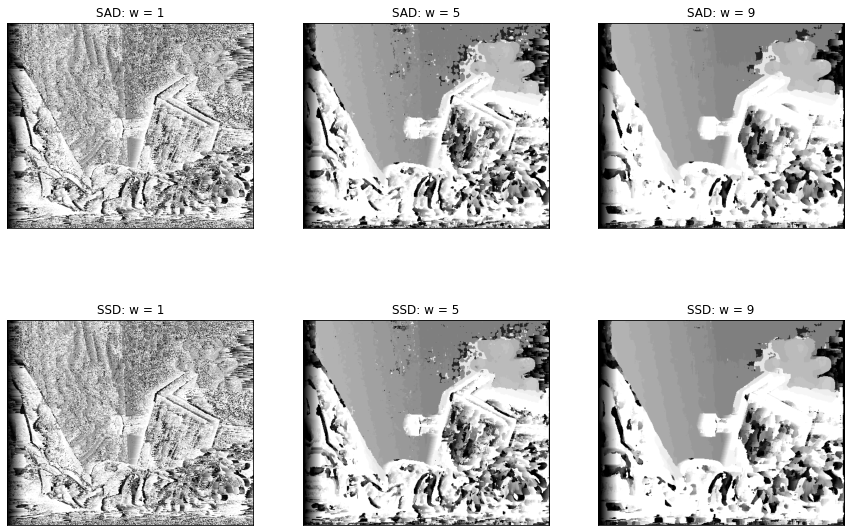

In [ ]:
disp_img3_SAD_1 = block_matching(img3_l, img3_r, calculate_SAD, np.argmin, 1, 30)
disp_img3_SAD_5 = block_matching(img3_l, img3_r, calculate_SAD, np.argmin, 5, 30)
disp_img3_SAD_9 = block_matching(img3_l, img3_r, calculate_SAD, np.argmin, 9, 30)
disp_img3_SSD_1 = block_matching(img3_l, img3_r, calculate_SSD, np.argmin, 1, 30)
disp_img3_SSD_5 = block_matching(img3_l, img3_r, calculate_SSD, np.argmin, 5, 30)
disp_img3_SSD_9 = block_matching(img3_l, img3_r, calculate_SSD, np.argmin, 9, 30)

plot_SAD_SSD_disp('Image 3 using SAD and SSD', disp_img3_SAD_1, disp_img3_SAD_5, 
                  disp_img3_SAD_9, disp_img3_SSD_1, disp_img3_SSD_5, disp_img3_SSD_9)

## Dynamic Programming

Calculate disparity using a dynamic programming algorithm to get the minimum cost of matching a whole row in the image.
Consider two scanlines I<sub>l</sub>(i) and I<sub>r</sub>(j). Pixels in each scanline may be matched, or skipped (considered to be occluded in either the left or right image). Let d<sub>ij</sub> be the cost associated with matching pixel I<sub>l</sub>(i) with pixel I<sub>r</sub>(j). Here we consider a squared error measure between pixels given by:
\begin{align*}
  d_{ij} &= \frac{(I_l (i) - I_r (j))^2}{σ^2}\\
\end{align*}

where σ is some measure of pixel noise. The cost of skipping a pixel (in either scanline) is given by a constant c<sub>0</sub> . For the experiments here we will use σ = 2 and c<sub>0</sub> = 1. Given these costs, we can compute the optimal (minimal cost) alignment of two scanlines recursively as follows:
\begin{align*}
  1. D(1,1) &= d_{11}\\
  2. D(i,j) &= min(D(i-1, j-1) + d_{ij}, D(i-1,j) + c_0, D(i, j-1) + c_0)\\
\end{align*}
The intermediate values are stored in an N-by-N matrix, D. The total cost of matching two scanlines is D(N, N). Note that this assumes the lines are matched at both ends (and hence have zero disparity there). This is a reasonable approximation provided the images are large relative to the disparity shift. You can find the disparity map of matching the left image to the right or vice versa at the same time or only calculate one of them. Given the cost matrix D we find the optimal alignment by backtracking. In particular, starting at (i, j) = (N, N), we choose the minimum value of D from (i - 1, j - 1), (i - 1, j), (i, j - 1). Selecting (i - 1, j) corresponds to skipping a pixel in I<sub>l</sub>
, so the left disparity map of i is zero. Selecting (i, j - 1) corresponds to skipping a pixel in I<sub>r</sub>, and the right disparity map of j is zero. Selecting (i - 1, j - 1) matches pixels (i, j), and therefore both disparity maps at this position are set to the absolute difference between i and j.


In [ ]:
def dynamic_programming(left_img, right_img, sigma, c0):
  n_cols = left_img.shape[1]
  left_disp = np.zeros(left_img.shape)
  right_disp = np.zeros(right_img.shape)
  for sl in range(left_img.shape[0]):
    D = np.zeros((n_cols, n_cols))
    D[0][0] = compute_d(int(left_img[sl][0]), int(right_img[sl][0]), sigma)
    for k in range(1, n_cols):
      D[0][k] = D[0][k-1] + c0
      D[k][0] = D[k-1][0] + c0
    for i in range(1, n_cols):
      for j in range(1, n_cols):
        cost = compute_d(int(left_img[sl][i]), int(right_img[sl][j]), sigma)
        D[i][j] = min(D[i-1][j-1] + cost, D[i-1][j] + c0, D[i][j-1] + c0)

    # backtracking
    i, j = n_cols - 1, n_cols - 1 
    while i != 0 and j != 0: 
      if D[i][j] == D[i-1][j-1] + compute_d(int(left_img[sl][i]), int(right_img[sl][j]), sigma):
        left_disp[sl][i] = abs(i - j)
        right_disp[sl][j] = abs(i - j)
        i -= 1
        j -= 1
      elif D[i][j] == D[i-1][j] + c0:
        left_disp[sl][i] = 0
        i -= 1
      elif D[i][j] == D[i][j-1] + c0:
        right_disp[sl][j] = 0
        j -= 1

  return normalize(left_disp, 255), normalize(right_disp, 255)    

In [ ]:
def compute_d(Il, Ir, sigma):
  return ((Il - Ir)**2) / (sigma**2)

In [ ]:
left_disp_1, right_disp_1 = dynamic_programming(img1_l, img1_r, 2, 1)
left_disp_2, right_disp_2 = dynamic_programming(img2_l, img2_r, 2, 1)
left_disp_3, right_disp_3 = dynamic_programming(img3_l, img3_r, 2, 1)

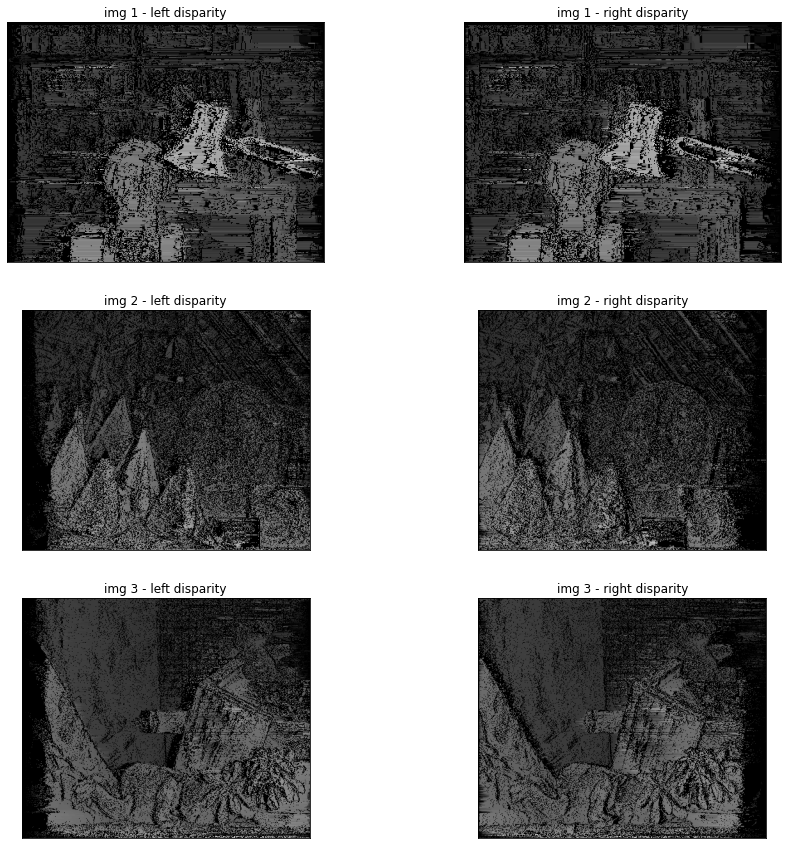

In [ ]:
fig = plt.figure(figsize=(15,15))
plot_img(fig, 3, 2, 1, left_disp_1, 'img 1 - left disparity')
plot_img(fig, 3, 2, 2, right_disp_1, 'img 1 - right disparity')
plot_img(fig, 3, 2, 3, left_disp_2, 'img 2 - left disparity')
plot_img(fig, 3, 2, 4, right_disp_2, 'img 2 - right disparity')
plot_img(fig, 3, 2, 5, left_disp_3, 'img 3 - left disparity')
plot_img(fig, 3, 2, 6, right_disp_3, 'img 3 - right disparity')

## Bonus

A good way to interpret your solution is to plot the alignment found for single scan line. Display the alignment by plotting a graph of Il (horizontal) vs Ir (vertical). Begin at D(N, N) and work backwards to find the best path. If a pixel in Il is skipped, draw a horizontal line. If a pixel in Ir is skipped, draw a vertical line. Otherwise, the pixels are matched, and you draw a diagonal line. The plot should end at (1, 1)

In [ ]:
def get_alignment(left_img, right_img, sl, sigma, c0):
  n_cols = left_img.shape[1]
  D = np.full(np.array((n_cols, n_cols)), np.inf)
  D[0][0] = compute_d(int(left_img[sl][0]), int(right_img[sl][0]), sigma)
  for i in range(1, n_cols):
    for j in range(1, n_cols):
      cost = compute_d(int(left_img[sl][i]), int(right_img[sl][j]), sigma)
      D[i][j] = min(D[i-1][j-1] + cost, D[i-1][j] + c0, D[i][j-1] + c0)
  
  # backtracking
  i, j = n_cols - 1, n_cols - 1
  points = [] 
  while i != 0 and j != 0: 
    if D[i][j] == D[i-1][j-1] + compute_d(int(left_img[sl][i]), int(right_img[sl][j]), sigma):
      i -= 1
      j -= 1
    elif D[i][j] == D[i-1][j] + c0:
      i -= 1
    else:
      j -= 1
    points.append([i,j])
  
  return np.array(points)

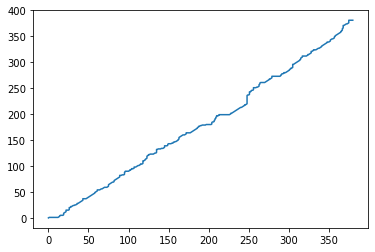

In [ ]:
points = get_alignment(img1_l, img1_r, 100, 2, 1)
plt.plot((points[:,0]), (points[:,1]))